## Beam Source Model

The beam source is emulated by using the `BeamSource` object. This includes a default method for creating molecule trajectories, and the default parameters are saved in the configuration file `./code/acme_simulation_parameters.py`. For now, this beam source allows for a normal distribution of times for leaving the cell. At the cell output aperture, it is assumed that the variance in the velocity is the same for all 3 cartesian directions, but the longitudinal direction is the only one that has non-zero mean. There are collimators, represented by `Collimator` objects, are used to collimate the beam - only trajectories that satisfy the contraints of all collimators are generated by the beam source method `generate_molecules` which takes as its argument the number of molecules that we would like to generate.

Any of the configuration parameters in the configuration file may be overwritten in any given instance of the BeamSource object by inserting the corresponding keyword arguments. The `generate_molecules` method returns a `Trajectory` object which contains information about all of the trajectories generated by the `BeamSource`. There are various methods included in the `Trajectory` object that enables characterization of the molecular beam. For each of these methods, a particular beam-line position, or a particular point in time must be specified to perform the characterization.

- `plot`: displays the trajectories of the molecules between two given positions along the x-axis, or plots the positions of all of the molecules at a fixed point in time.
- `statistics`: displays some statistics for each of the trajectory parameters ($x$, $y$, $z$, $v_x$, $v_y$, $v_z$) including the mean, std, min, and max of the distributions.
- `histogram`: displays either an array of all pairwise correlation plots of all trajectory parameters, or if there are string inputs corresponding to those parameters, then a 1d, or 2d histogram can be generated for any single trajectory parameter or pair of trajectory parameters.

In [132]:
%matplotlib inline
import sys
sys.path.append('./code')
sys.path.append('../DatabaseAccess/code')

from database_access import load
from beam_source import BeamSource, SimulationParameters,\
GratingCollimator, SimpleMultiCollimator, RectangleCollimator, EllipticalCollimator, PolygonGratingCollimator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1)
sns.set_style('white')

Here is an example of using the `BeamSource` to generate 1000 molecule trajectories and saving those trajectories for later use - often when performing Monte Carlo, you want a random ensemble to work with, but you want to work with the same random ensemble when changing parameters. The default simulation parameters are held in a `SimulationParameters` object. This object can be instantiated and passes to the BeamSource, but if not, BeamSource creates a new instance of this object on its own.

In [2]:
bs = BeamSource()
trj = bs.generate_molecules(1000)
trj.save()

saved: ./saved/1000_trajectories_2016-03-03T15-19.pkl


These trajectories may be loaded by using the `load` function in the `DatabaseAccess` directory, which is nice because it prompts the user to select an existing file. Note that the saved trajectories object also has a copy of the `BeamSource` object that created it so that the settings that generated the trajectories will not be lost, and so that more trajectories can be created later using the same settings if needed.

In [3]:
trj = load(directory='./saved')
bs  = trj.beam_source

0    ./saved/1000_trajectories_2016-03-03T00-19.pkl
1    ./saved/1000_trajectories_2016-03-03T00-53.pkl
2    ./saved/1000_trajectories_2016-03-03T14-42.pkl
3    ./saved/5000_trajectories_2016-03-02T18-52.pkl
4    ./saved/5000_trajectories_2016-03-03T00-18.pkl
5     ./saved/500_trajectories_2016-03-02T23-27.pkl
6     ./saved/500_trajectories_2016-03-02T23-29.pkl
7     ./saved/500_trajectories_2016-03-03T00-18.pkl
dtype: object
input an integer corresponding to the file that you would like to load: 2
loaded: ./saved/1000_trajectories_2016-03-03T14-42.pkl


Here are some statistics regarding the trajectories that were generated, and here is a plot of all of the trajectories that includes the collimator positions, and points where the trajectories intersect the collimator planes. Here, you can see the conical aperture near $x=0$, and the square fixed collimator near $x=1$ m.

(6, 1000, 3)


C:\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


,unit,mean,dmean,std,min,max,N
t,s,0.00802984,1.87276e-05,0.000592219,0.00659906,0.0106438,1000
v_x,m/s,181.58,0.393682,12.4493,137.061,220.084,1000
v_y,m/s,0.0688838,0.0382649,1.21004,-2.56929,2.60235,1000
v_z,m/s,-0.0589289,0.0376935,1.19197,-2.49439,2.37148,1000
x,m,1.45,1.42766e-17,4.51466e-16,1.45,1.45,1000
y,m,0.000211155,0.000298083,0.00942621,-0.0165683,0.016678,1000
z,m,-0.000469393,0.000295789,0.00935367,-0.0165766,0.0165298,1000


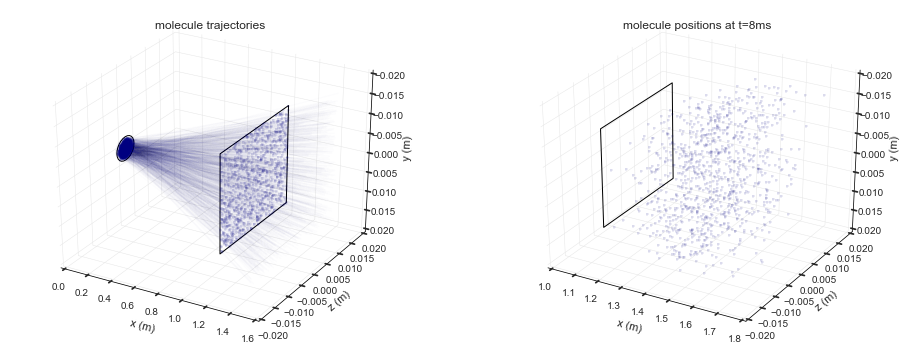

In [4]:
plt.figure(figsize=(16,6))
ax = plt.subplot(1,2,1, projection='3d')
trj.plot(lmin=0, lmax=bs.params.READOUT_POSITION, ax=ax)
plt.title('molecule trajectories')

ax = plt.subplot(1,2,2, projection='3d')
trj.plot(t=.008, ax=ax)
plt.title('molecule positions at t=8ms')

trj.statistics(l=bs.params.READOUT_POSITION)

Here is the generic histogram plot showing all of the pairwise correlation plots, and single variable histograms for each of the trajectory parameters. This shows at a fixed position corresponding roughly to the **read-out position** along the beamline, that there is

- an asymmetry to the arrival time $t$ distribution due to velocity dispersion
- a correlation between $v_x$ and $t$ due to velocity dispersion
- a delta function spike distribution for $x$ (since we fixed x)
- a strong correlation between $y$ and $v_y$, and $z$ and $v_z$, since the upstream conical aperture size is small compared to the downstream fixed collimator.
- it looks like there is a weak correlation between arrival time $t$ and the distribution width of for $v_y$ and $v_z$.I admit, I don't fully understand the effect causing this.

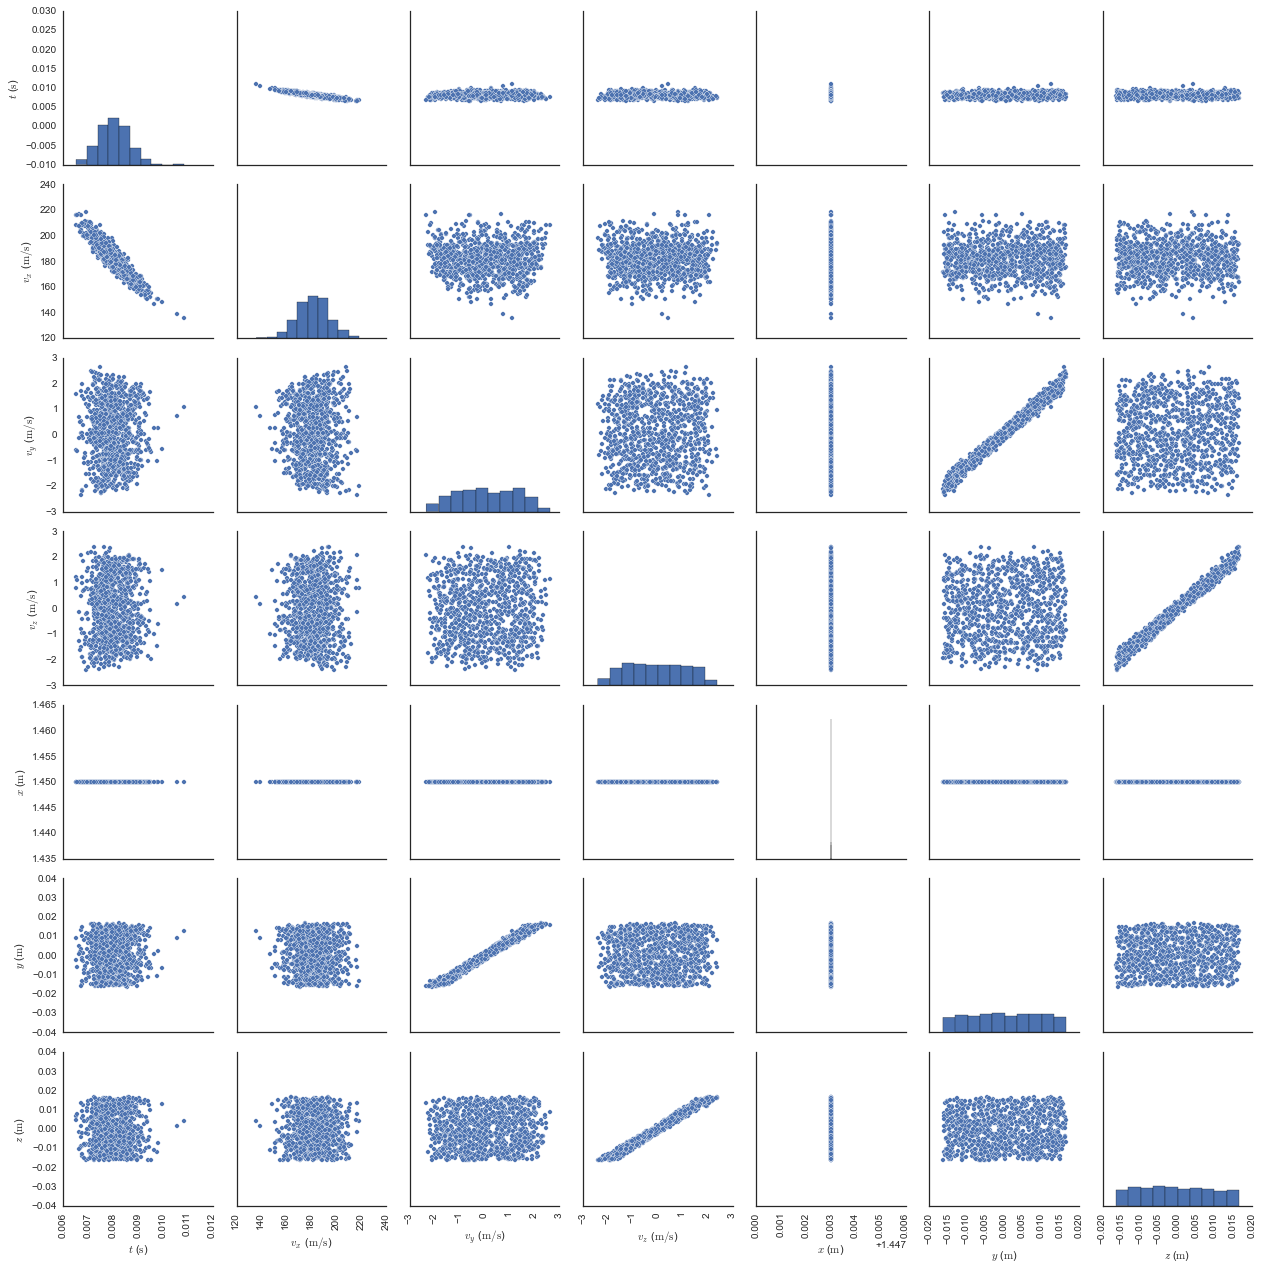

In [5]:
_=trj.histogram(l=bs.params.READOUT_POSITION)

We will be able to use this trajectories object in order to obtain, for example, the position of the molecules vs. time, or doppler shift vs. time, for performing a simulation of the experiment.

In [6]:
print 'positions in m: \n', trj.position(t=.001)[:10,:], '\n'
print '690 nm doppler shifts in rad/s: \n', trj.doppler_shift(690*10**(-9), [0, 1, 0],
                                                    bs.params.READOUT_POSITION)[:10]

positions in m: 
[[ 0.16953823 -0.00149699 -0.00046582]
 [ 0.19523614 -0.00337306  0.00076636]
 [ 0.16511413  0.00050924 -0.0020945 ]
 [ 0.19022417  0.00224604 -0.00228679]
 [ 0.14532687 -0.00314815  0.00112837]
 [ 0.20749214  0.00200003  0.00123753]
 [ 0.13713041  0.00209048 -0.00146744]
 [ 0.16866347  0.00250768 -0.00064844]
 [ 0.19235576 -0.00172827  0.00309848]
 [ 0.1697822   0.00294922 -0.00088466]] 

690 nm doppler shifts in rad/s: 
[-12285856.77459258 -14774847.01646129  21324159.33074436   3731721.0330406
  -8985173.1900744    7067654.90202194  10296052.01542502
   3995456.75530126 -10908092.1221089    8601476.00427761]


Note that I can easily modify the `BeamSource` object such that the parameters and the collimators are modified. Here, the beam velocity is slowed down such that gravity has a much greater effect on the trajectories. Additionally, I am introducing a more complex grating collimation geometry. The gratings are rotated by random angles on the 1 degree level to represent imprecision in alignment.

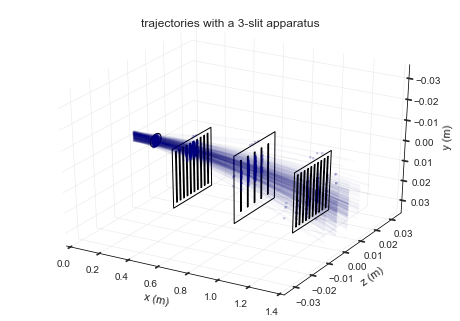

In [87]:
bs2 = BeamSource()
bs2.params.SOURCE_VELOCITY_PARAMETERS = ((25, 0, 0), (.1, .1, .1))

X = (.4, .8, 1.2)
N = (10, 5, 10)
spacing = (.002, .004, .002)
Z = (0, .002, 0)

bs2.collimators = [GratingCollimator(x, z = z, y=.01,
                                        width=.0005,
                                        spacing=s,
                                        length=.025,
                                        N_slits=n, 
                                        include_outside=True, 
                                        angle= 1 * np.random.randn())  
                   for x, z, n, s in zip(X, Z, N, spacing)]
bs2.collimators.append(EllipticalCollimator(x=.15, r=.003, y=0))
trj2 = bs2.generate_molecules(500, timeout=10)
trj2.plot(0, 1.4)
_ = plt.title('trajectories with a 3-slit apparatus')

For this perverse case, here is a correlation plot between $z$ and $v_z$

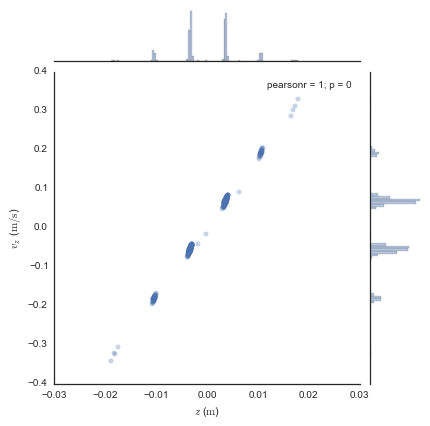

In [88]:
trj2.histogram('z', 'v_z', 
               l=1.4, 
               alpha=.3,
               marginal_kws=dict(bins=100))

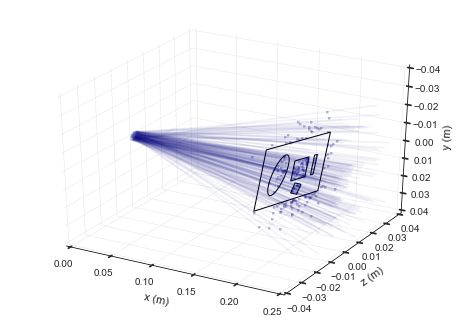

In [68]:
x = .2

collimators = [RectangleCollimator(x=x, d=.01),
               RectangleCollimator(x=x, y=.01, d=.005, angle=20),
               RectangleCollimator(x=x, z=.01, d_y=.01, d_z=.002),
               EllipticalCollimator(x=x, z=-.015, r_y=.01, r_z=.005, angle=20),
               RectangleCollimator(x=x, z=-.005, d_y=.03, d_z=.045, pass_outside=True)]

c = SimpleMultiCollimator(collimators, 
                          y=0, angle=15, origin=(0,0))

bs = BeamSource()
v = 10
dv = .5
bs.params.SOURCE_VELOCITY_PARAMETERS = ((v,0,0),(dv,dv,dv))
bs.collimators = [c]

bs.generate_molecules(200).plot(0,.25)

In [ ]:
class ForceProfile(object):
    
    def __init__(self, force, t=None, dt=None):
        pass
        
    def symplectic_integration

class ForcedTrajectory(BallisticTrajectory):
    """
    extends ballistic trajectory to include a force that
    acts on the molecules that depends on space and time
    """
    
    def __init__(self, force, dt, *args, **kwargs):
        
        super(ForcedTrajectory, self).__init__(self, *args, **kwargs):
            

In [4]:
def safety_offset(ss, dss, sc, dsc, l1, l2, ref):
    return ref - np.abs(((sc/2.0 + dsc) + (((sc/2.0 + dsc) - (-ss/2.0 + dss))) * (l2 / l1)))

In [25]:
location(7,-1, 23.6, .4, 1.10, .4968, 20.341)

0.59867272727272791

In [32]:
def sample(N = 100):
    da = np.random.normal(size=(N,))
    db = np.random.normal(size=(N,))
    result = location(7,1 * da, 23.6, .4 + .2 * db, 1.10, .4968, 20.341)
    return np.mean(result), np.std(result)

In [33]:
sample()

(1.0613156706666116, 0.58717181300367527)

In [28]:
location(7,0, 24, 0, 1.10, .4968, 20.341)

1.3406363636363636

In [29]:
location(7,0, 23.6, .4, 1.10, .4968, 20.341)

1.0503090909090886

In [31]:
location(7,-1, 23.6, .6, 1.10, .4968, 20.341)

0.30834545454545648

In [34]:
location(7,0, 24, 0, 1.10, .4968, 45/2.0)

3.4996363636363625